# Pre-activate ResNEt
: 기존 ResNet에서는 f를 ReLU 함수와 BN을 사용합니다. 이 활성화 함수(ReLU와 BN)의 위치를 바
꿔준다면 f를 identity mapping으로 만들 수 있습니다

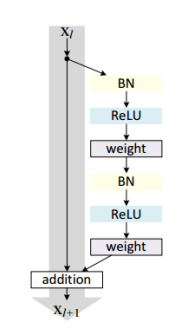

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets,transforms

import matplotlib.pyplot as plt


In [7]:
class BasicBlock(nn.Module):
    expansion =1
    def __init__(self, in_channels, out_channels,stride=1):
        super(BasicBlock, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels,out_channels, kernel_size=3,stride=1, padding=1, bias=True)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)


        #잔차 연결 residual connection
        self.shortcut = nn.Sequential()  #초기화

        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False)
            )
        

    def forward(self, x):
        out = F.relu(self.bn1(x))
        residual = out

        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))       #bn2 -> relu -> conv2

        ## 기존 self.shortcut을 가지고 있는지 확인
        if hasattr(self, 'shortcut'):
            residual = self.shortcut(x)
        out += residual


        return out





In [8]:
class PreActResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(PreActResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1, bias=False)
      

        #Residual Block 레이어들을 생성하기 위해 _make_layer 호출
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avepool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512* block.expansion, num_classes)



    ########## '_'가 붙은 함수 : 내부 매서드 -> class내에서 반복적으로 사용됨
    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion   #in_channel 업데이트

        # residual block생성, layer추가
        for _ in range(1, blocks):
            #in_channel -> 이전 설정한 출력/
            layers.append(block(self.in_channels, out_channels))
        
        print('layers', layers)
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avepool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

        

In [9]:
def resnet34(num_classes=1000):
    return PreActResNet(BasicBlock, [3,4,6,3], num_classes)



In [10]:
model = resnet34(num_classes=1000)
inputs = torch.randn(1,3,224,224)
output = model(inputs)
print(output)

layers [BasicBlock(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (shortcut): Sequential()
), BasicBlock(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (shortcut): Sequential()
), BasicBlock(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

RuntimeError: The size of tensor a (224) must match the size of tensor b (112) at non-singleton dimension 3